In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout

In [3]:
# Load the Excel file
file_path = r"C:\Users\navab\Downloads\Magnificient_7_same_base_data.xlsx"
excel_data = pd.ExcelFile(file_path)

In [5]:
excel_data

In [25]:
def process_company_data(sheet_name, data, time_steps, for_periods):
    '''
    task in this section:
    Process the data for a single company( one after the another).

    :param sheet_name: Name of the sheet (company) to process
    :param data: DataFrame with data for the company
    :param time_steps: number of input time steps
    :param for_periods: number of output time steps

    :returns(output): Trained models and their predictions
    '''
    # Prepare the data
    data = data.replace('#N/A N/A', 0)  # Replace '#N/A N/A' with 0
    data.fillna(0, inplace=True)  # Fill remaining NaN values with 0
    data['Dates'] = pd.to_datetime(data['Dates'], format='%d/%m/%Y')
    data.set_index('Dates', inplace=True)
    
    # Extract relevant columns
    data = data[['PX_CLOSE_1D']]  # You can adjust which columns to use

    # Plot the closing prices
    sns.set(rc={'figure.figsize': (15, 9)})
    data['PX_CLOSE_1D'].plot(grid=True)
    plt.title(f'{sheet_name} - PX_CLOSE_1D', color='black', fontsize=20)
    plt.xlabel('Year', color='black', fontsize=15)
    plt.ylabel('Stock Price', color='black', fontsize=15)
    plt.show()

    # Prepare training and test data
    X_train, y_train, X_test, sc = ts_train_test(data, time_steps, for_periods)

    # Define and train RNN model
    my_rnn_model, rnn_predictions = simple_rnn_model(X_train, y_train, X_test, sc)
    
    # Define and train LSTM model
    my_lstm_model, lstm_predictions = LSTM_model(X_train, y_train, X_test, sc)
    
    # Define and train GRU model
    my_gru_model, gru_predictions = GRU_model(X_train, y_train, X_test, sc)
    
    # Extract actual values for the period
    actual_values = data['PX_CLOSE_1D'].loc['2017':].values[:len(rnn_predictions)]

    # Plot the results
    title_txt = f'{sheet_name} - RNN Model Predictions'
    actual_pred_plot(actual_values, rnn_predictions, title_txt)
    
    title_txt = f'{sheet_name} - LSTM Model Predictions'
    actual_pred_plot(actual_values, lstm_predictions, title_txt)
    
    title_txt = f'{sheet_name} - GRU Model Predictions'
    actual_pred_plot(actual_values, gru_predictions, title_txt)
    
    # Compute and print RMSE for each model
    rmse_rnn = np.sqrt(mean_squared_error(actual_values, rnn_predictions[:, 0]))
    rmse_lstm = np.sqrt(mean_squared_error(actual_values, lstm_predictions[:, 0]))
    rmse_gru = np.sqrt(mean_squared_error(actual_values, gru_predictions[:, 0]))

    print(f'{sheet_name} - RNN RMSE: {rmse_rnn:.4f}')
    print(f'{sheet_name} - LSTM RMSE: {rmse_lstm:.4f}')
    print(f'{sheet_name} - GRU RMSE: {rmse_gru:.4f}')


In [27]:
# Define a function to create training and test data
def ts_train_test(data, time_steps, for_periods):
    '''
    task in this section
    Create training and test sets, scale data

    :param data: DataFrame with dates and price data
    :param time_steps: number of input time steps
    :param for_periods: number of output time steps

    :returns(output): X_train, y_train: data from 2012-2016
              X_test:  data from 2017 onward
              sc: instantiated MinMaxScaler object fit to the training data
    '''
    ts_train = data['2012':'2016'].iloc[:, 0:1].values
    ts_test = data['2017':].iloc[:, 0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # Feature scaling
    sc = MinMaxScaler(feature_range=(0, 1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # Create training data of samples and time steps
    X_train = []
    y_train = []
    for i in range(time_steps, ts_train_len - for_periods + 1):
        X_train.append(ts_train_scaled[i - time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i + for_periods, 0])

    # Convert X_train and y_train to numpy arrays
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshape X_train to 3-D array
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Prepare to create X_test
    inputs = pd.concat((data["PX_CLOSE_1D"]['2012':'2016'], data["PX_CLOSE_1D"]['2017':]), axis=0).values
    inputs = inputs[len(inputs) - len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1, 1)
    inputs = sc.transform(inputs)

    # Create X_test
    X_test = []
    for i in range(time_steps, len(ts_test) + time_steps - for_periods + 1):
        X_test.append(inputs[i - time_steps:i, 0])

    # Convert X_test to numpy array
    X_test = np.array(X_test)

    # Reshape X_test to 3-D
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, sc

In [29]:
# Define the RNN model
def simple_rnn_model(X_train, y_train, X_test, sc):
    '''
    task for thsi section:
    Create RNN model trained on X_train and y_train
    and make predictions on the X_test data

    :param X_train: input features for training the model
    :param y_train: output features for training the model
    :param X_test:  test data to make predictions on
    :param sc: instantiated MinMaxScaler object fit to the training data

    :returns(output): trained model and array of predicted prices to original scale
    '''
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2))  # The time step of the output is 2
    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')
    my_rnn_model.fit(X_train, y_train, epochs=200, batch_size=150, verbose=0)
    rnn_predictions = my_rnn_model.predict(X_test)
    rnn_predictions = sc.inverse_transform(rnn_predictions)
    return my_rnn_model, rnn_predictions


In [31]:
def actual_pred_plot(actuals, preds, title_txt):
    '''
    tasks for this section
    Plot the actual vs. predicted prices

    :param actuals: array of actual prices
    :param preds: array of predicted prices
    :param title_txt: Title of the plot
    '''
    # Create dataframe containing actual and predicted prices
    actual_dates = pd.date_range(start='2017-01-01', periods=len(preds), freq='B')
    actual_pred = pd.DataFrame({
        'Actual': actuals,
        'Prediction': preds[:, 0]
    }, index=actual_dates)

    # Calculate mean squared error
    mse = mean_squared_error(actuals, preds[:, 0])
    rmse = np.sqrt(mse)
    print(f"RMSE score: {rmse:.4f}")

    # Plot actual vs predicted prices
    sns.set(rc={'figure.figsize': (15, 9)})
    plt.figure()
    plt.plot(actual_pred.index, actual_pred['Actual'], label='Actual', color='blue')
    plt.plot(actual_pred.index, actual_pred['Prediction'], label='Prediction', color='red')
    plt.title(title_txt, color='black', fontsize=20)
    plt.xlabel('Date', color='black', fontsize=15)
    plt.ylabel('Stock Price', color='black', fontsize=15)
    plt.legend()
    plt.grid(True)
    plt.show()


In [33]:
# Define the LSTM model
def LSTM_model(X_train, y_train, X_test, sc):
    """
    tasks for this section
    Create LSTM model trained on X_train and y_train
    and make predictions on the X_test data

    :param X_train: input features for training the model
    :param y_train: output features for training the model
    :param X_test:  test data to make predictions on
    :param sc: instantiated MinMaxScaler object fit to the training data

    :returns(output): trained model and array of predicted prices to original scale
    """
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dropout(0.2))
    my_LSTM_model.add(Dense(units=2))
    my_LSTM_model.compile(optimizer='adam', loss='mean_squared_error')
    my_LSTM_model.fit(X_train, y_train, epochs=200, batch_size=150, verbose=0)
    LSTM_predictions = my_LSTM_model.predict(X_test)
    LSTM_predictions = sc.inverse_transform(LSTM_predictions)
    return my_LSTM_model, LSTM_predictions

In [35]:
# Define the GRU model
def GRU_model(X_train, y_train, X_test, sc):
    '''
    tasks for this section
    Create GRU model trained on X_train and y_train
    and make predictions on the X_test data

    :param X_train: input features for training the model
    :param y_train: output features for training the model
    :param X_test:  test data to make predictions on
    :param sc: instantiated MinMaxScaler object fit to the training data

    :returns(output): trained model and array of predicted prices to original scale
    '''
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
    my_GRU_model.add(GRU(units=50, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units=2))
    my_GRU_model.compile(optimizer='adam', loss='mean_squared_error')
    my_GRU_model.fit(X_train, y_train, epochs=200, batch_size=150, verbose=0)
    GRU_predictions = my_GRU_model.predict(X_test)
    GRU_predictions = sc.inverse_transform(GRU_predictions)
    return my_GRU_model, GRU_predictions

Processing sheet: Apple


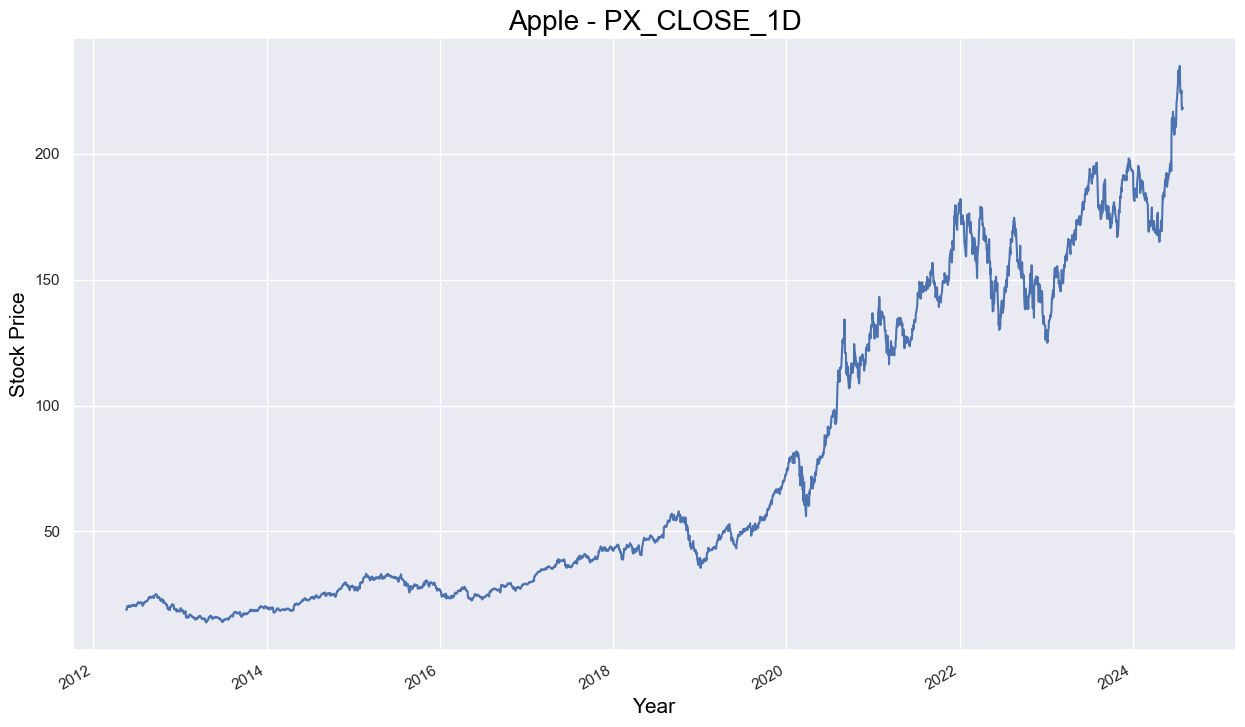

C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
RMSE score: 70.7170


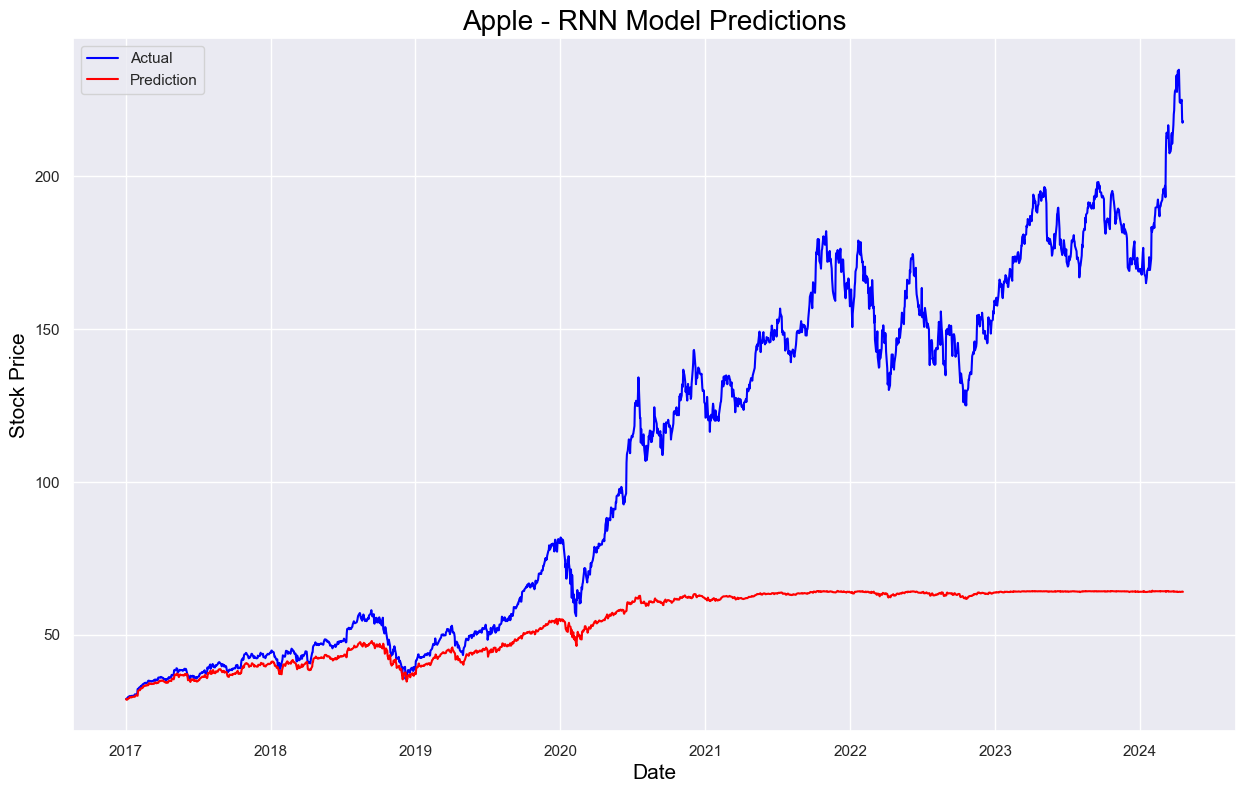

RMSE score: 61.6518


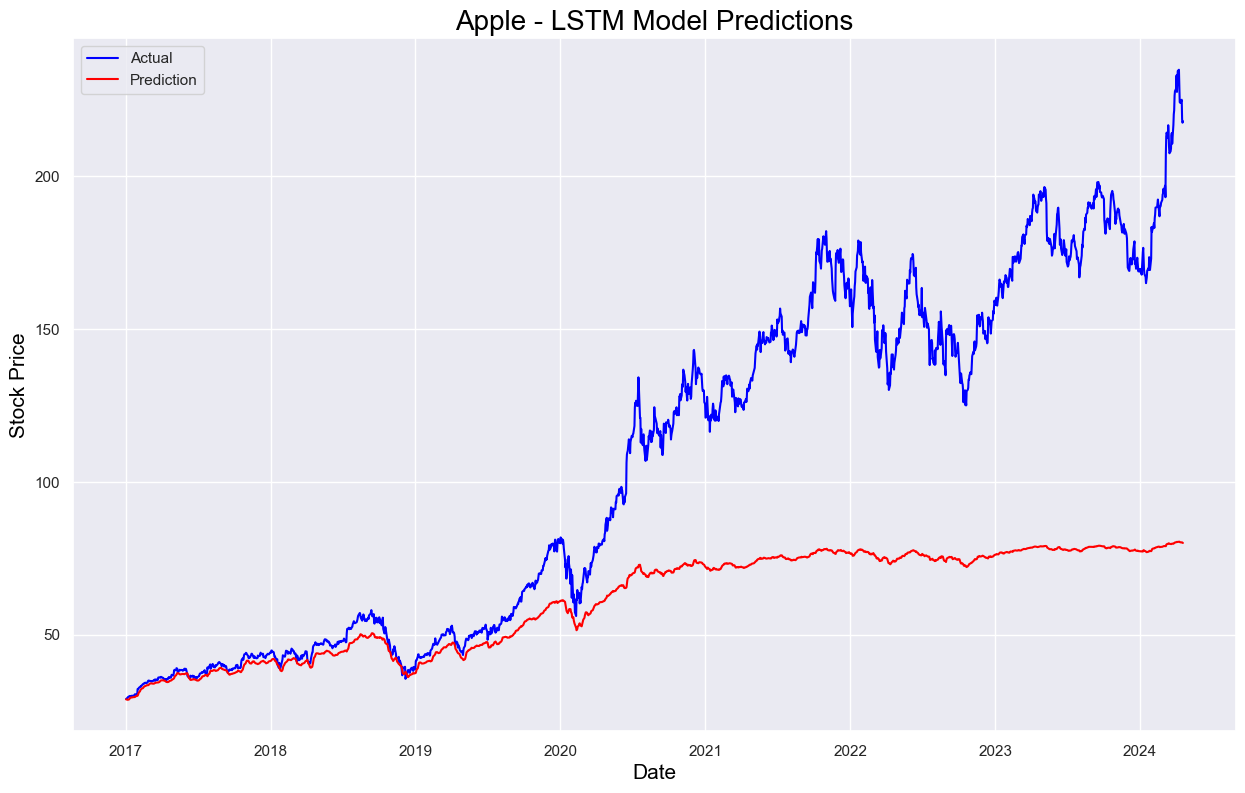

RMSE score: 39.2381


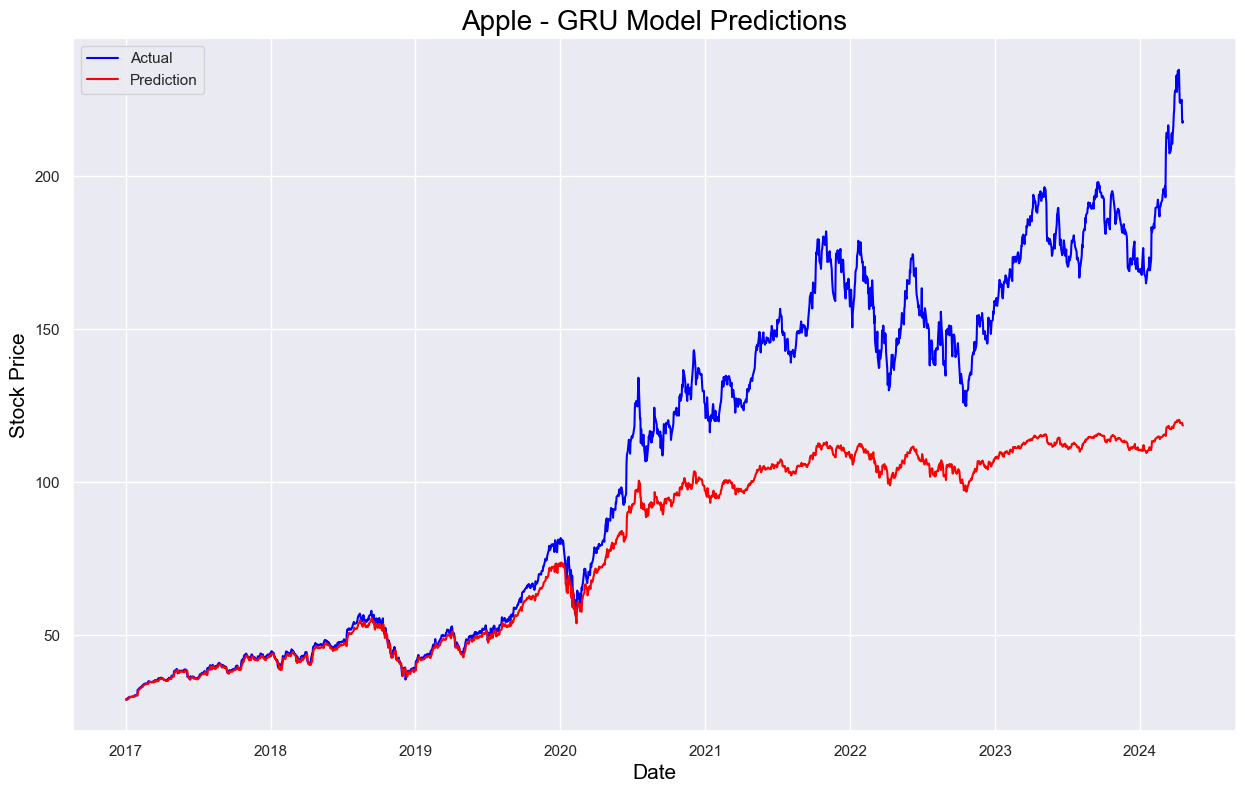

Apple - RNN RMSE: 70.7170
Apple - LSTM RMSE: 61.6518
Apple - GRU RMSE: 39.2381
Processing sheet: Microsoft


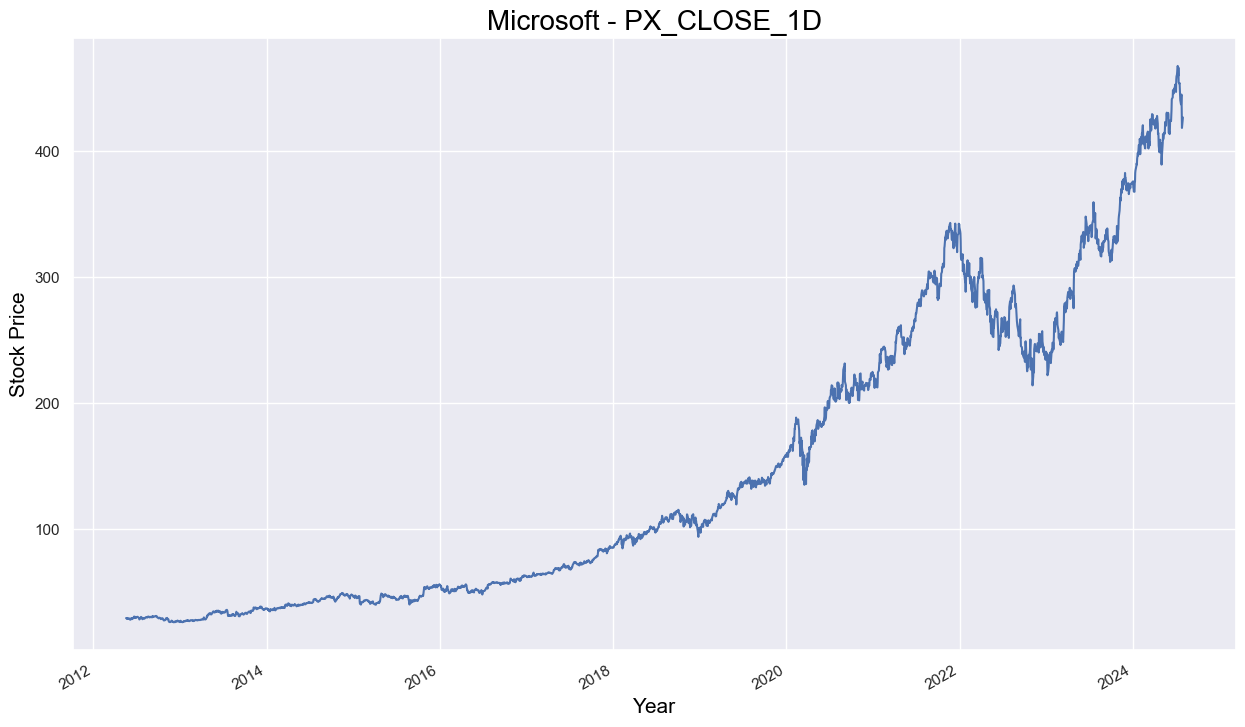

C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
RMSE score: 161.3773


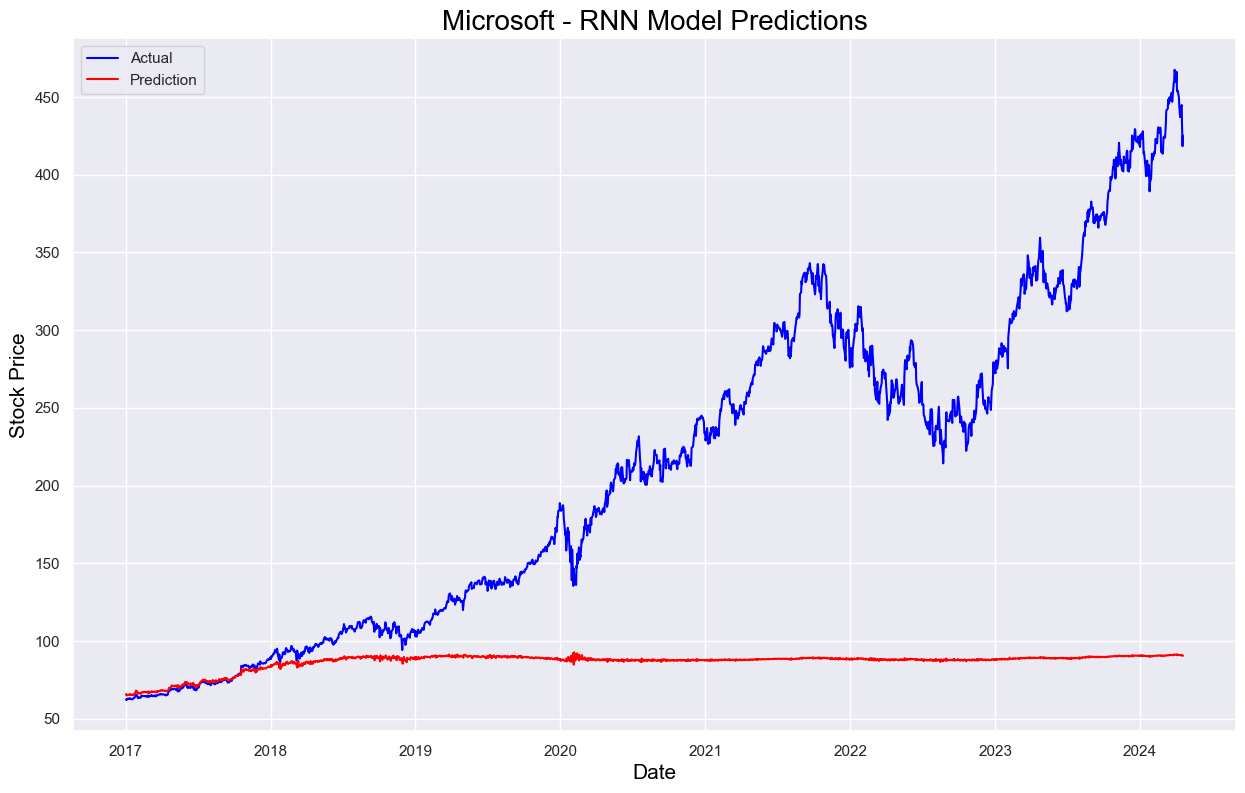

RMSE score: 110.2872


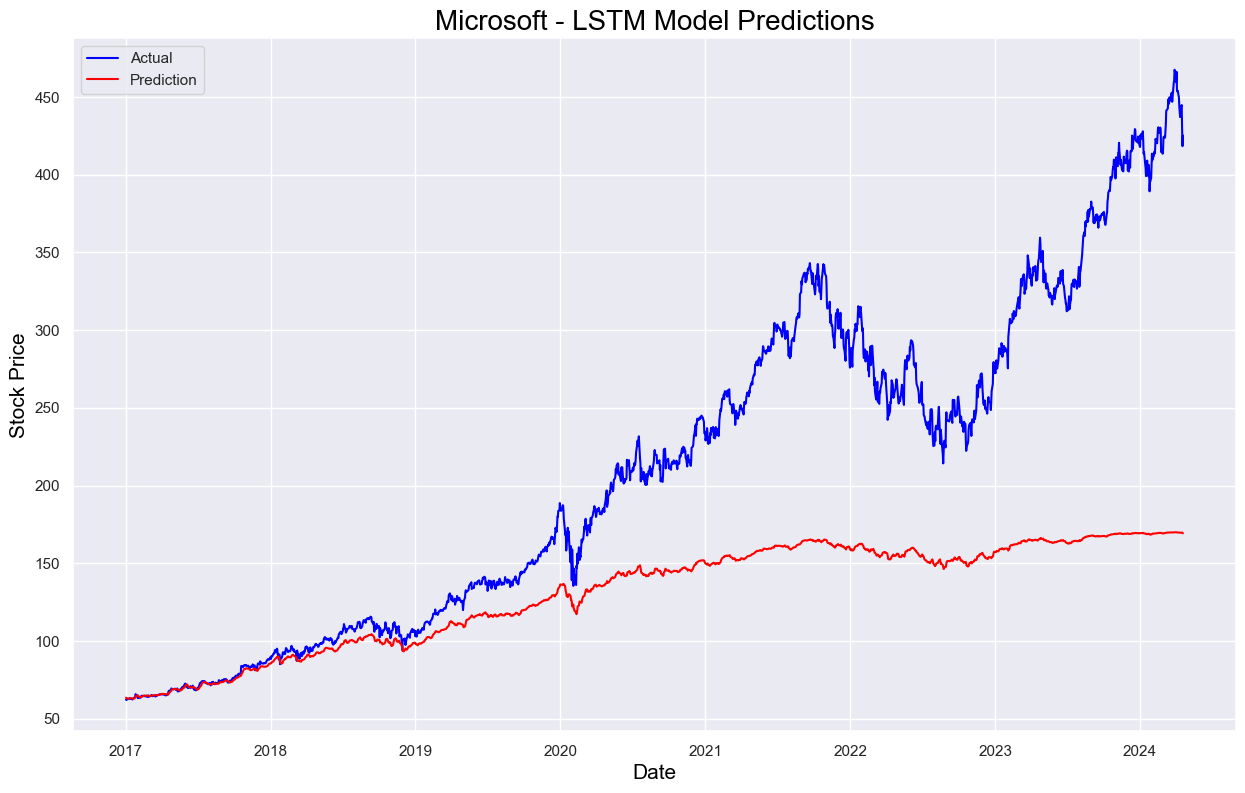

RMSE score: 76.9454


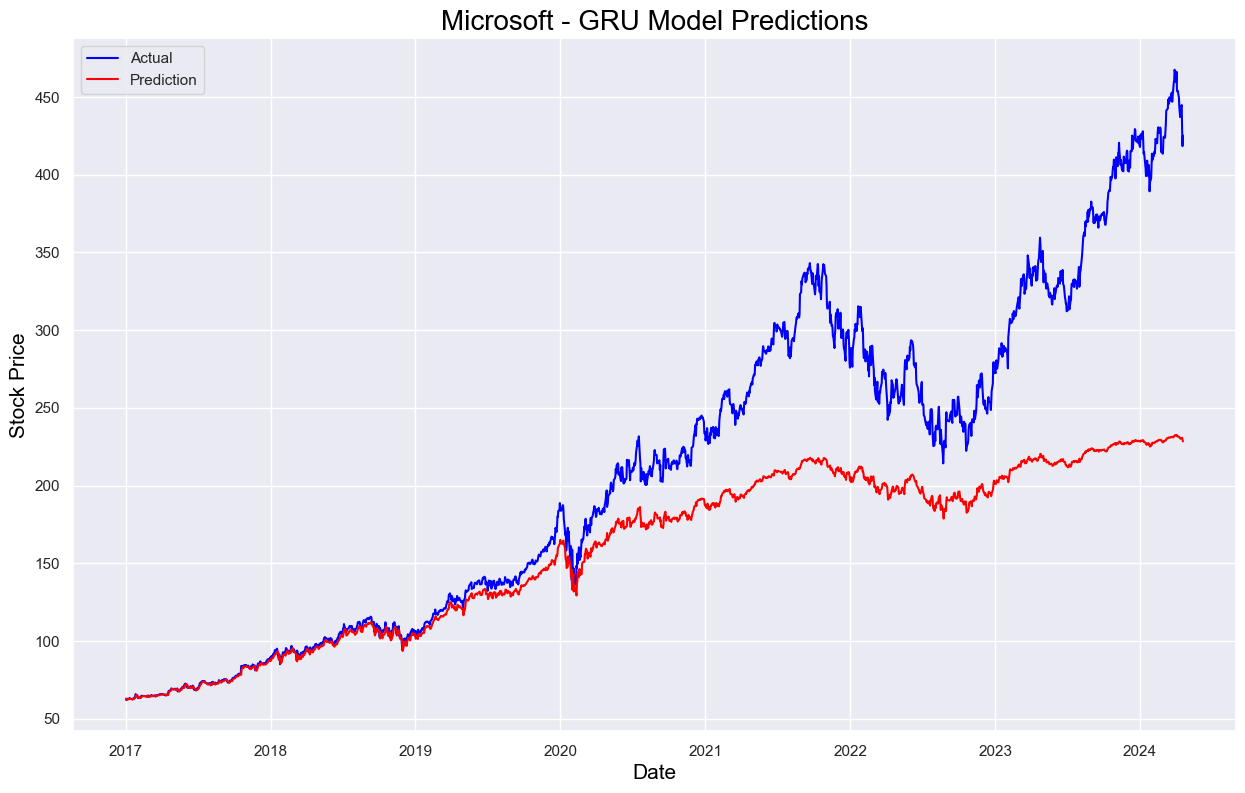

Microsoft - RNN RMSE: 161.3773
Microsoft - LSTM RMSE: 110.2872
Microsoft - GRU RMSE: 76.9454
Processing sheet: Nvidia


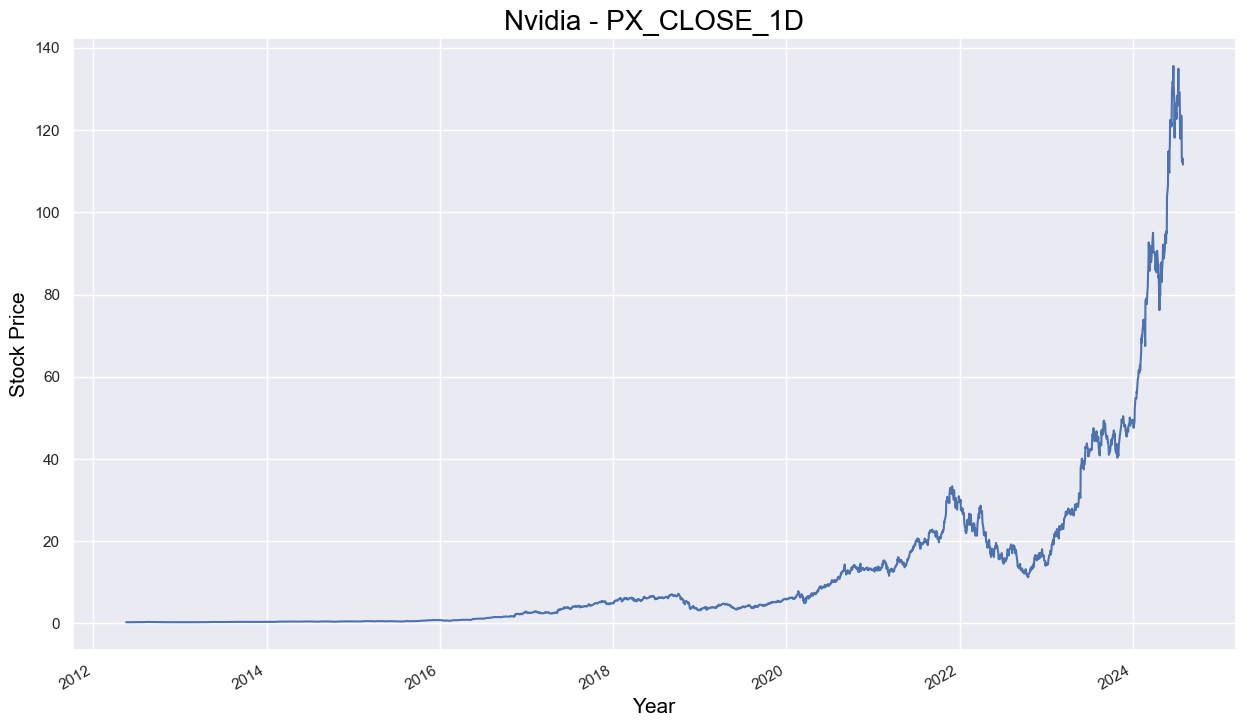

C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
RMSE score: 27.5200


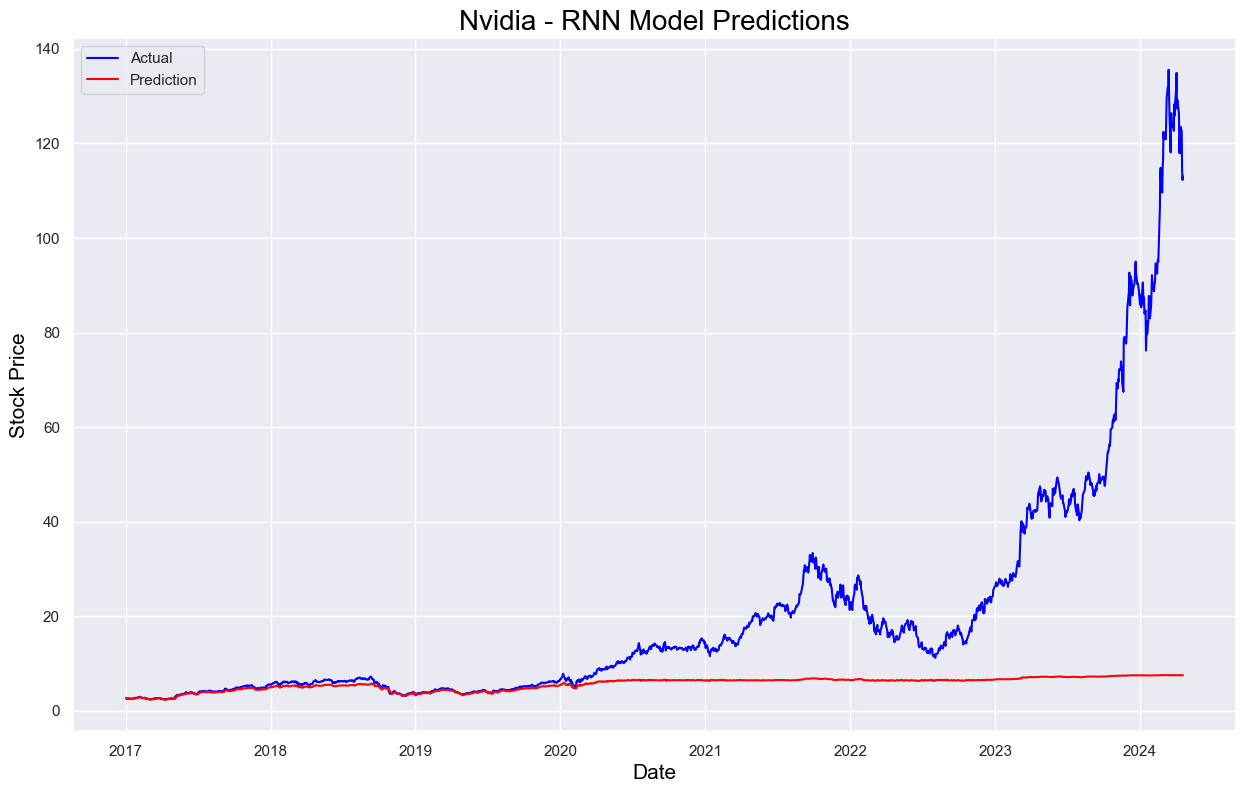

RMSE score: 26.9622


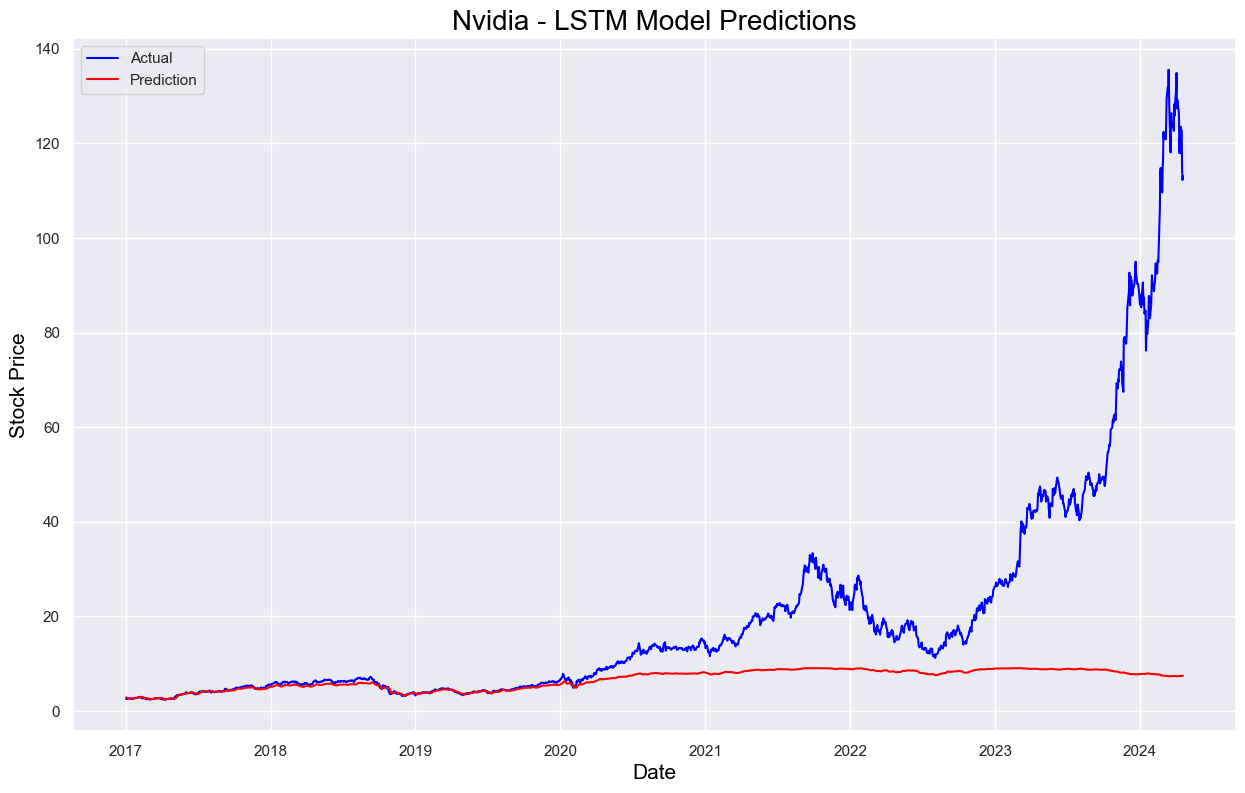

RMSE score: 23.9252


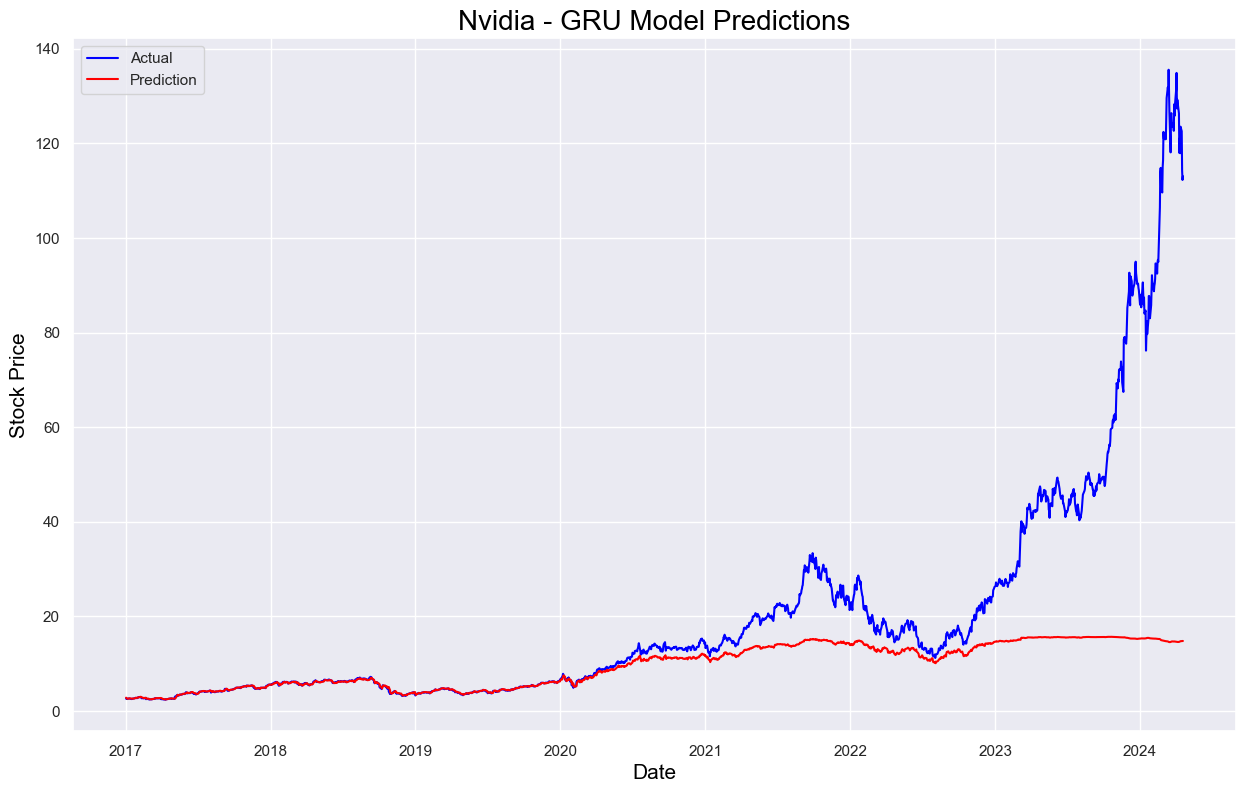

Nvidia - RNN RMSE: 27.5200
Nvidia - LSTM RMSE: 26.9622
Nvidia - GRU RMSE: 23.9252
Processing sheet: Amazon


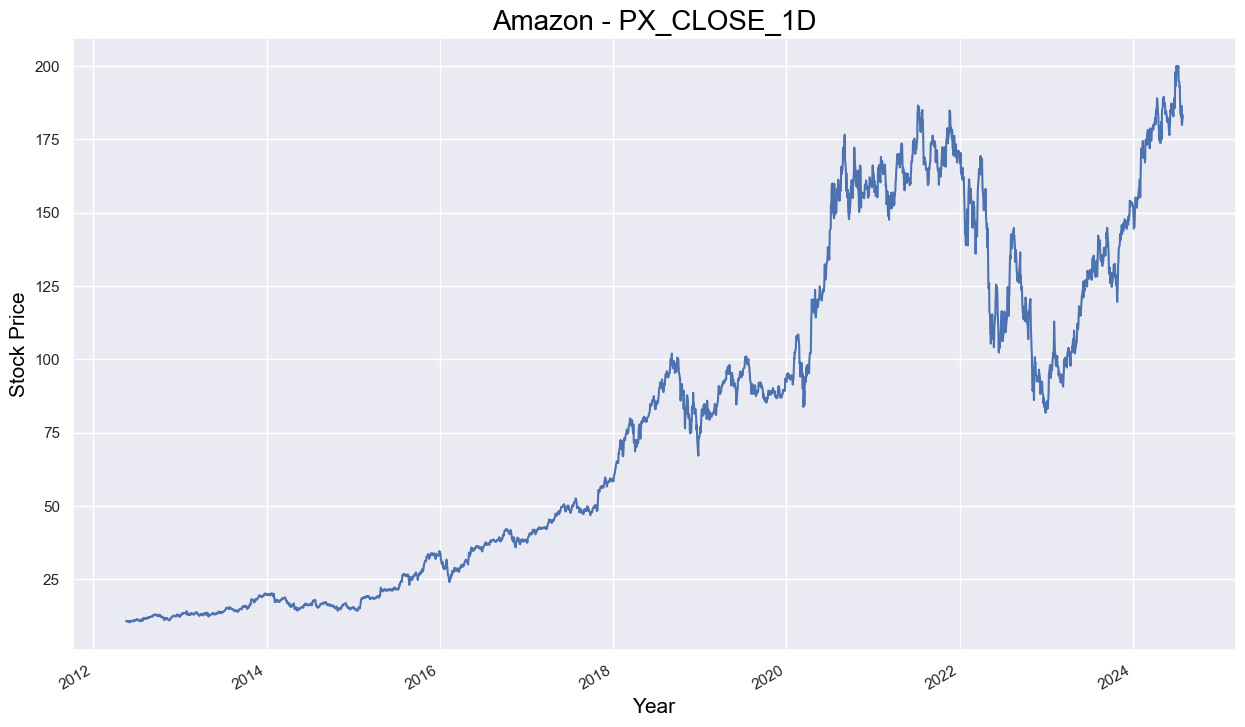

C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
RMSE score: 47.7725


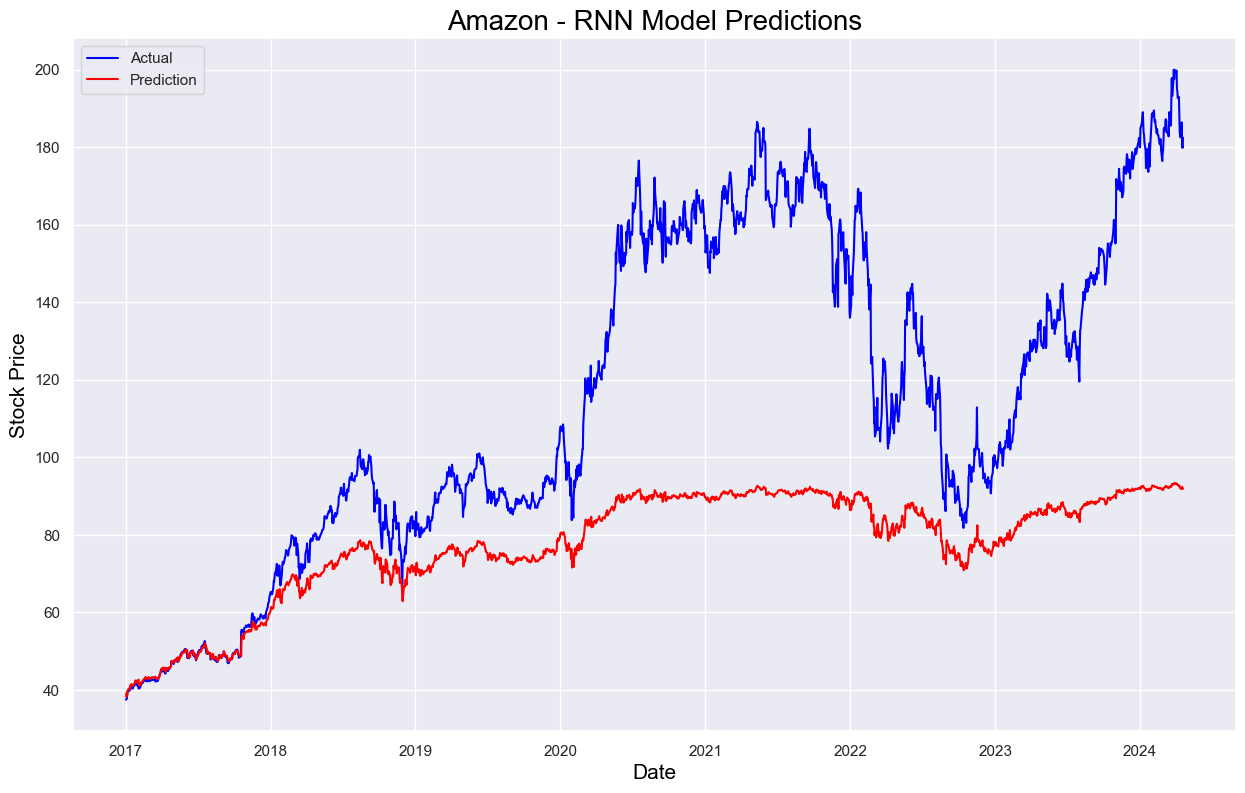

RMSE score: 44.5939


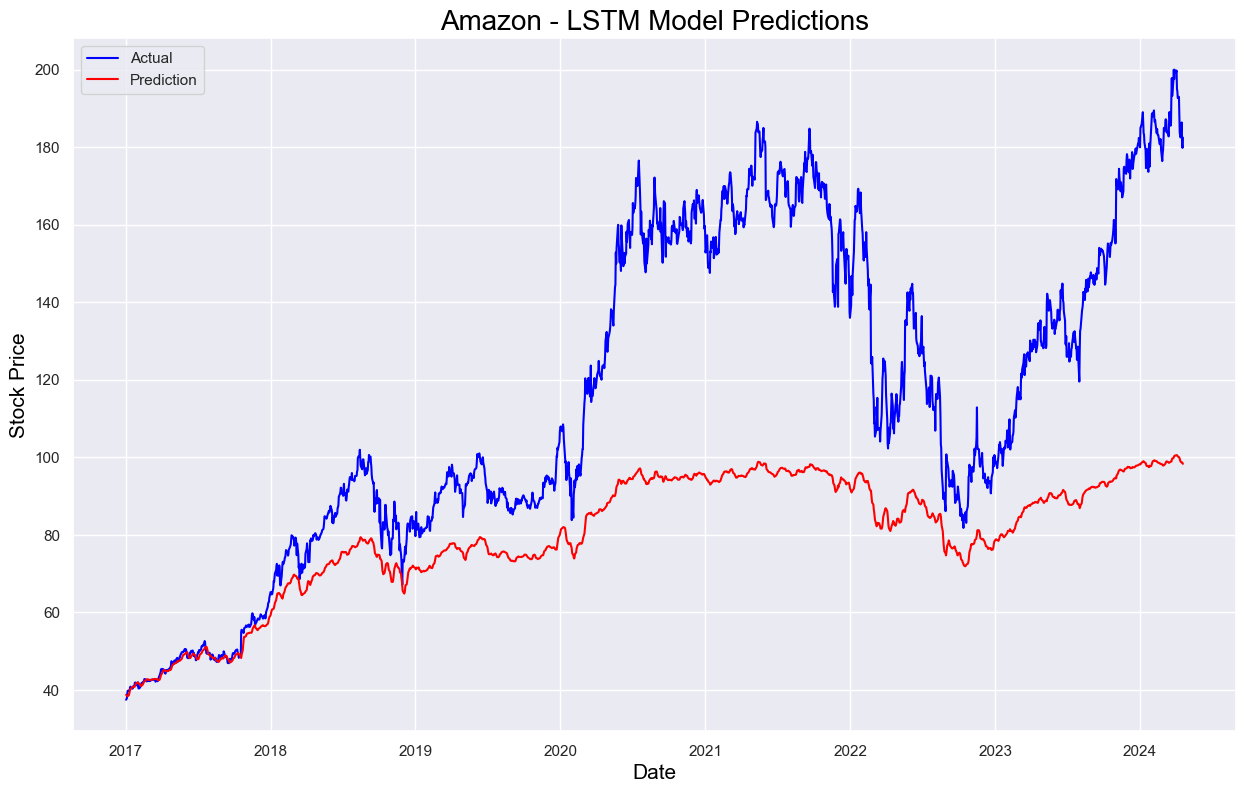

RMSE score: 23.8667


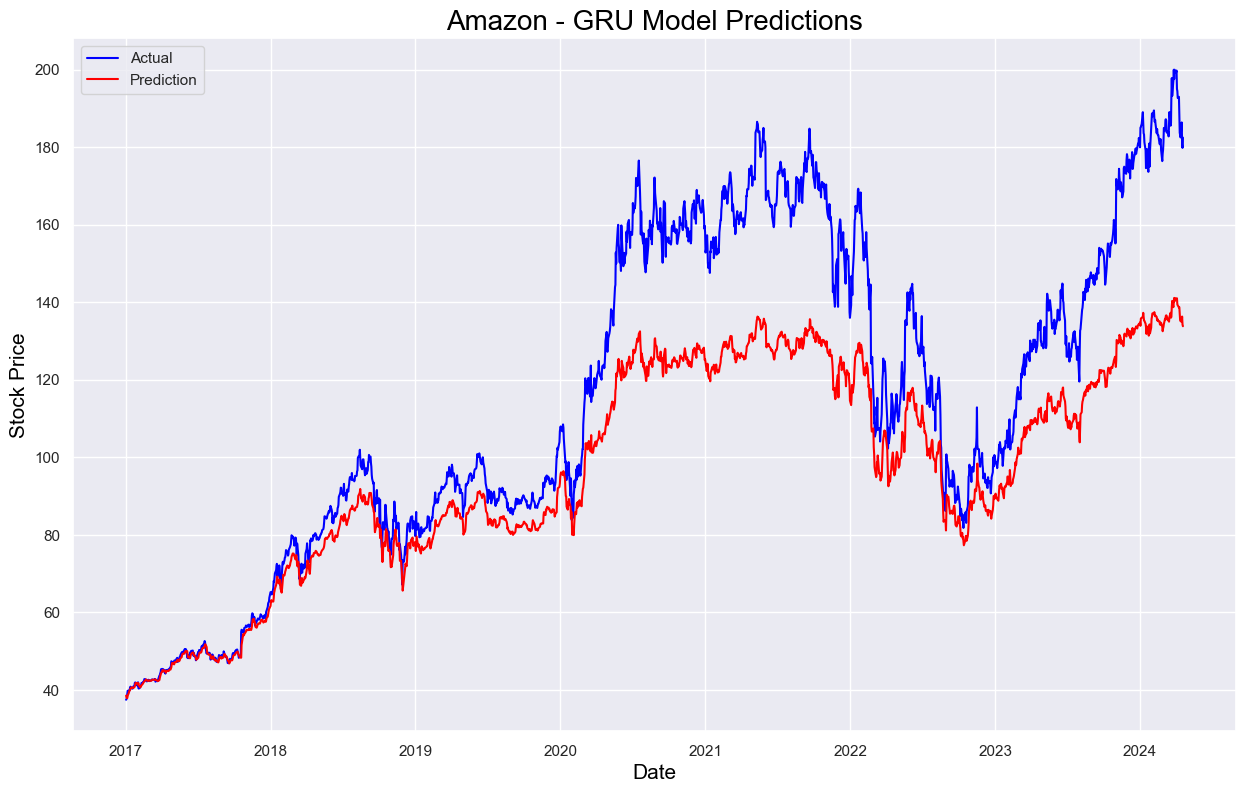

Amazon - RNN RMSE: 47.7725
Amazon - LSTM RMSE: 44.5939
Amazon - GRU RMSE: 23.8667
Processing sheet: Google


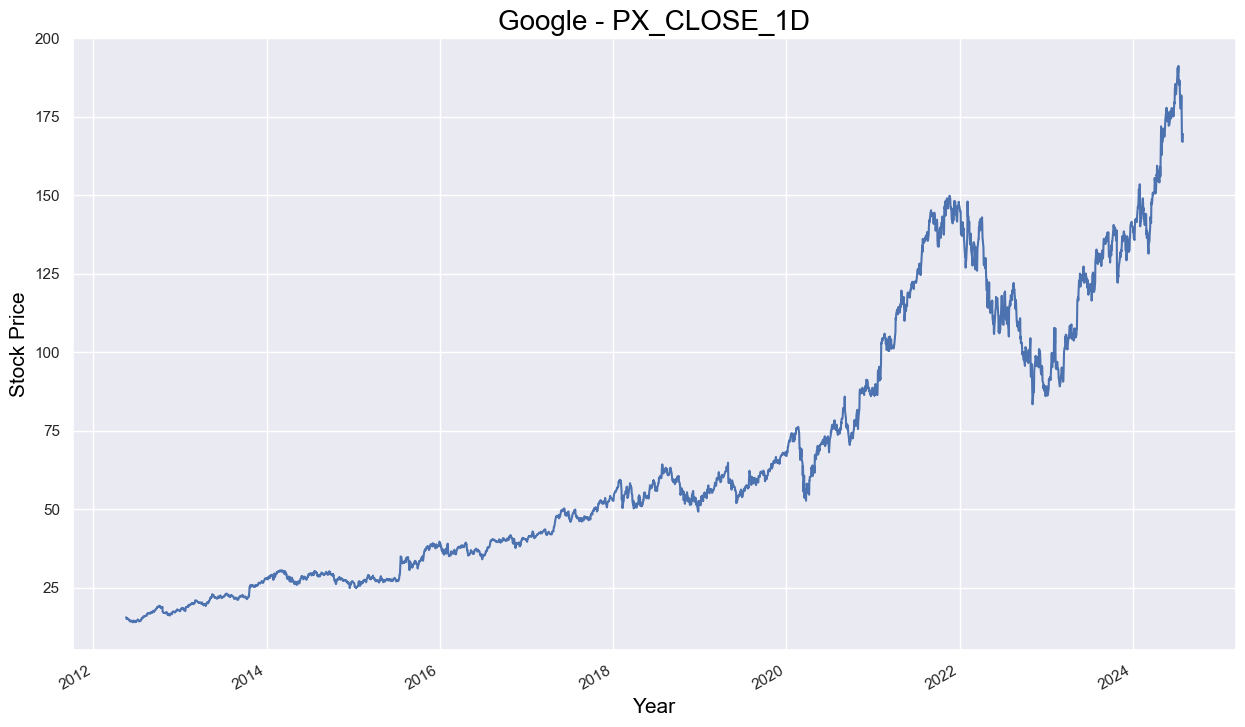

C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
RMSE score: 39.8825


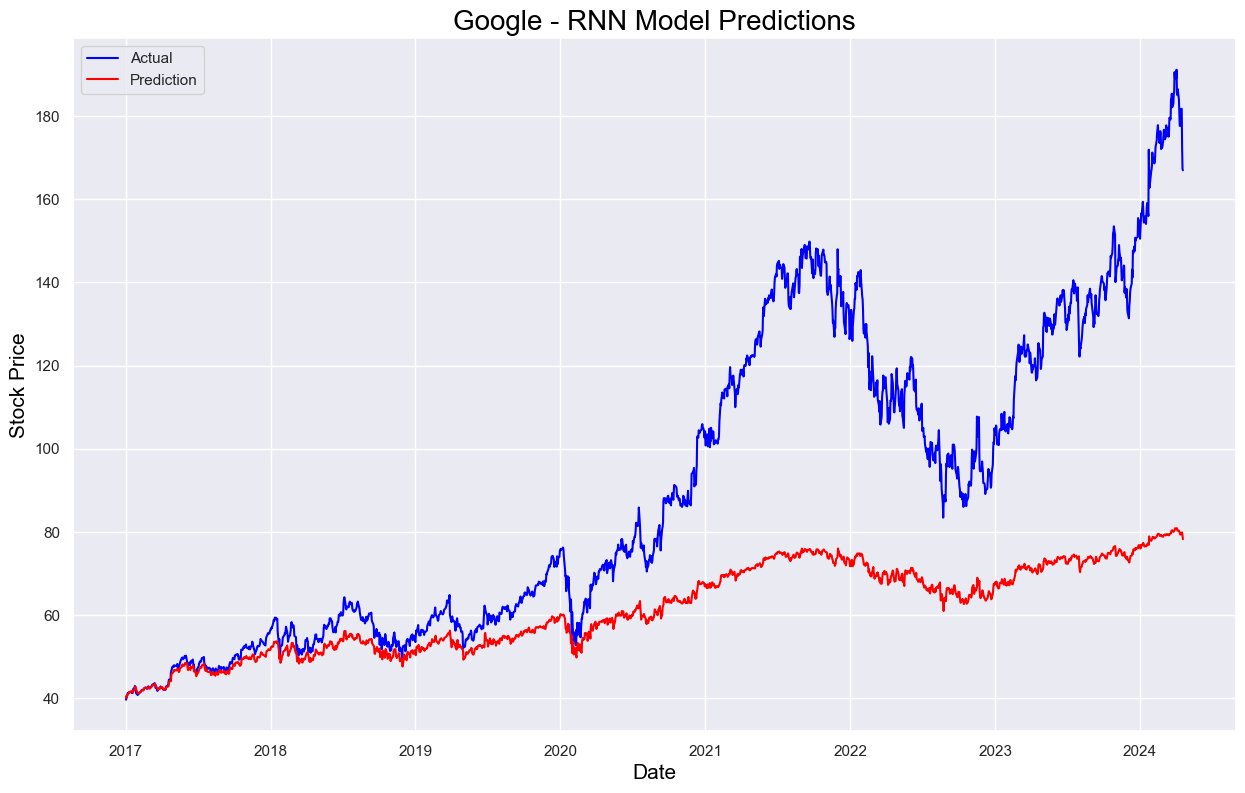

RMSE score: 31.5487


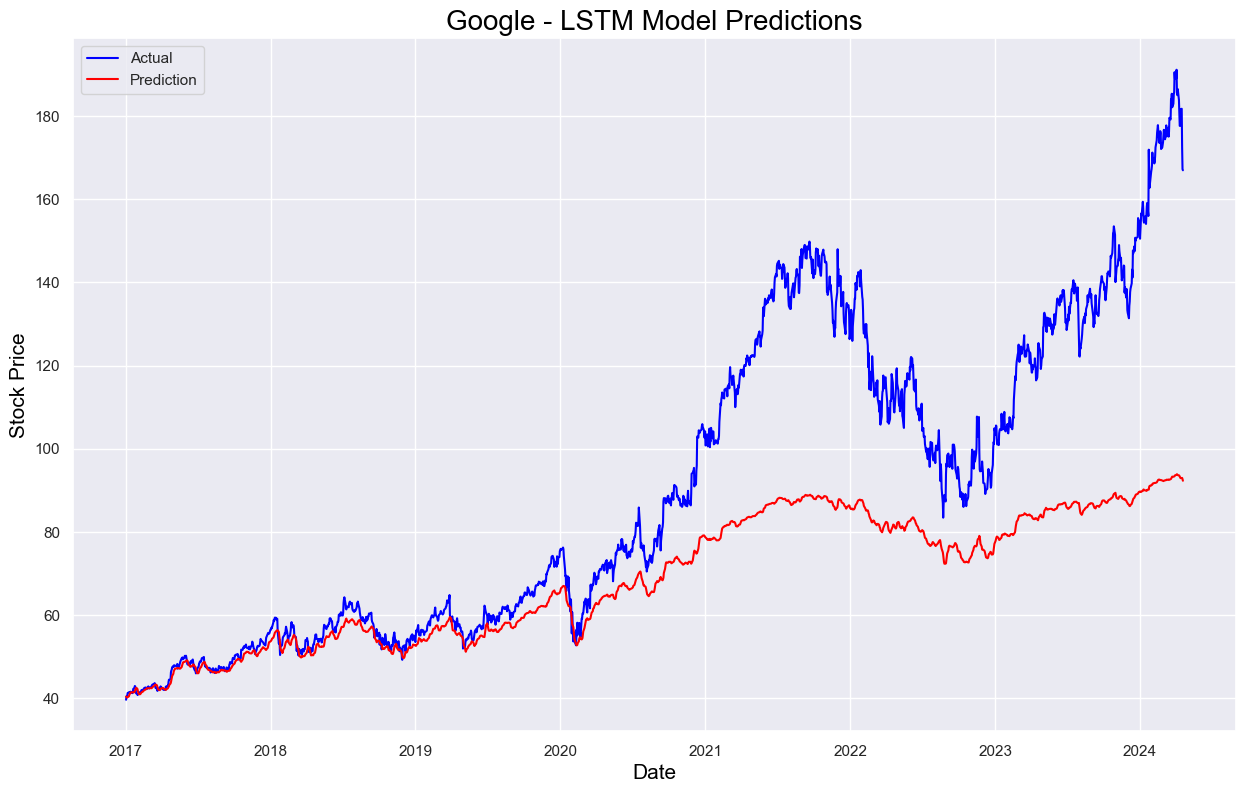

RMSE score: 12.2716


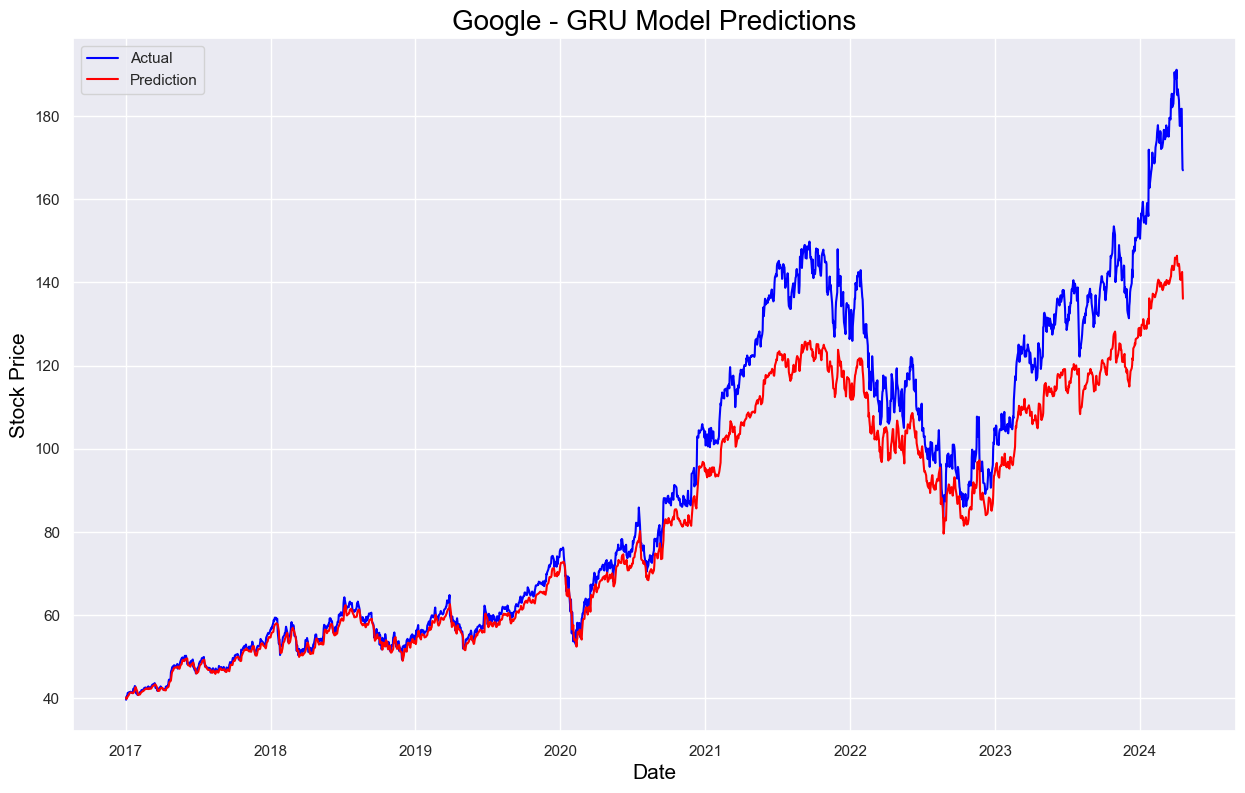

Google - RNN RMSE: 39.8825
Google - LSTM RMSE: 31.5487
Google - GRU RMSE: 12.2716
Processing sheet: Tesla


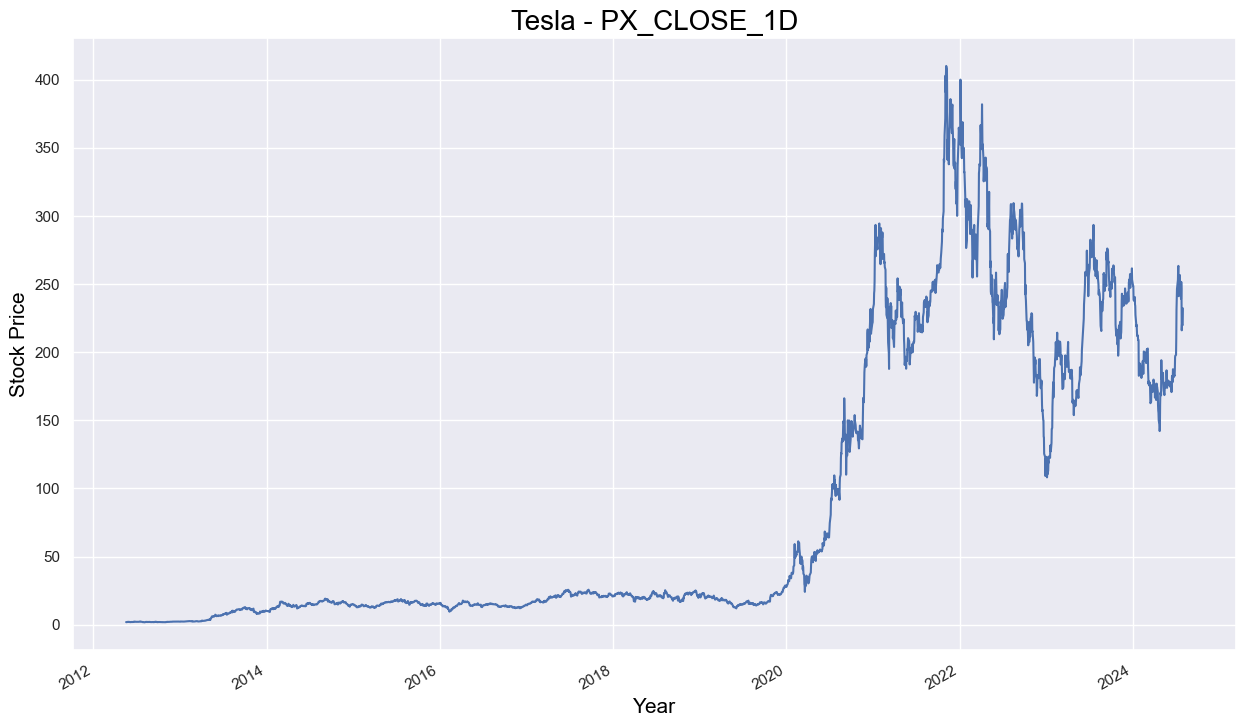

C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
RMSE score: 140.6460


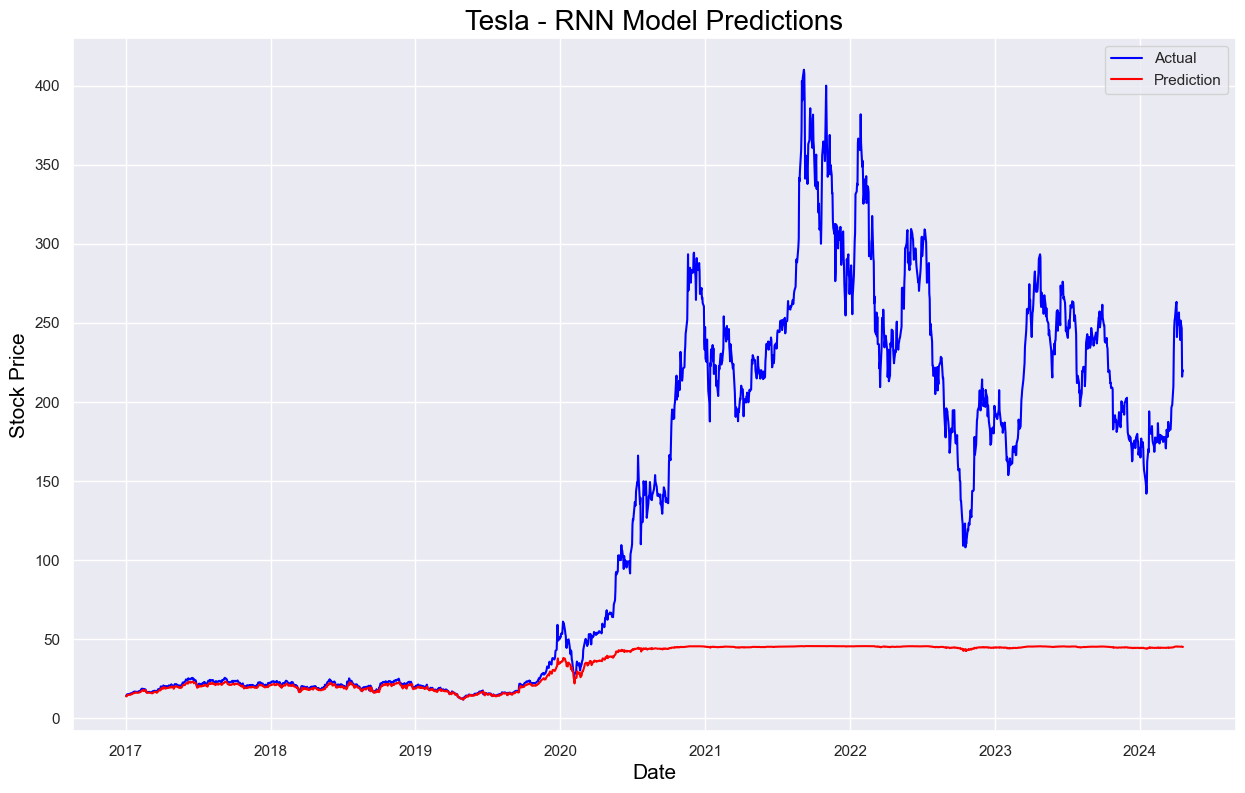

RMSE score: 136.1875


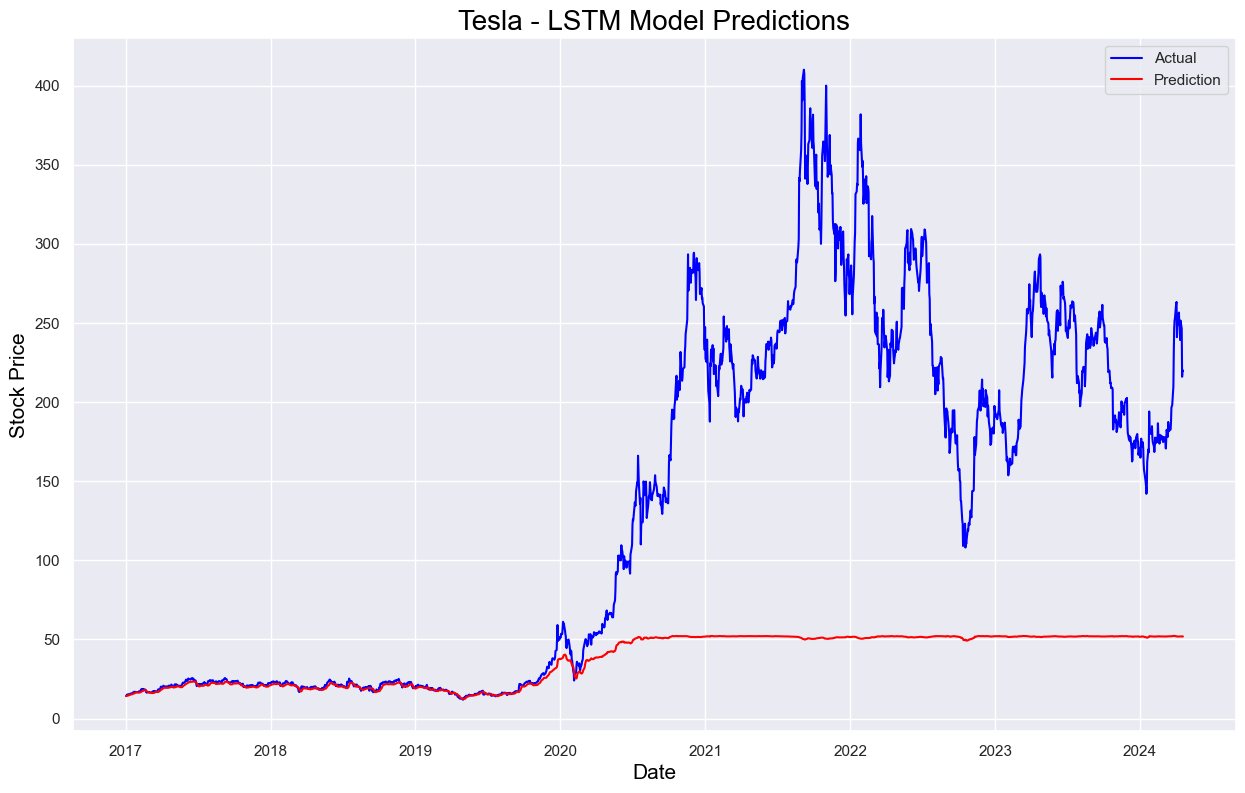

RMSE score: 102.9193


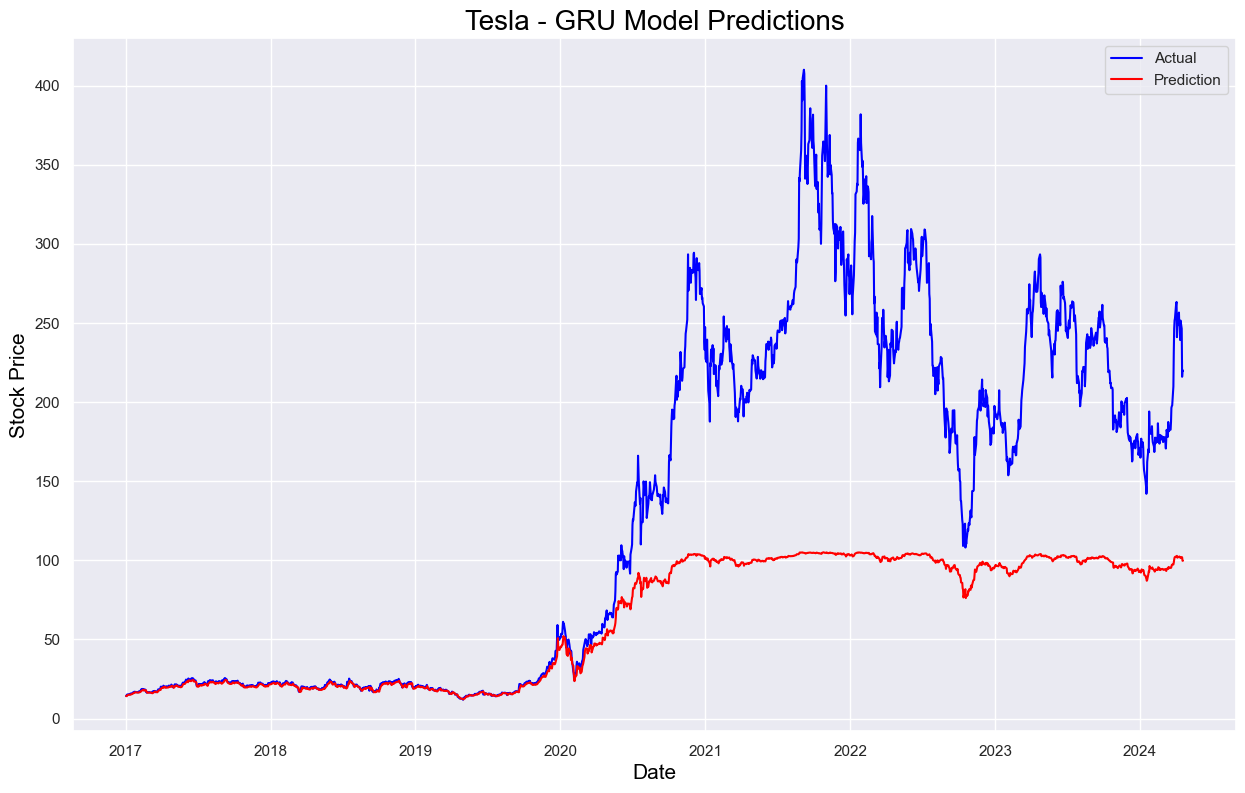

Tesla - RNN RMSE: 140.6460
Tesla - LSTM RMSE: 136.1875
Tesla - GRU RMSE: 102.9193
Processing sheet: Meta


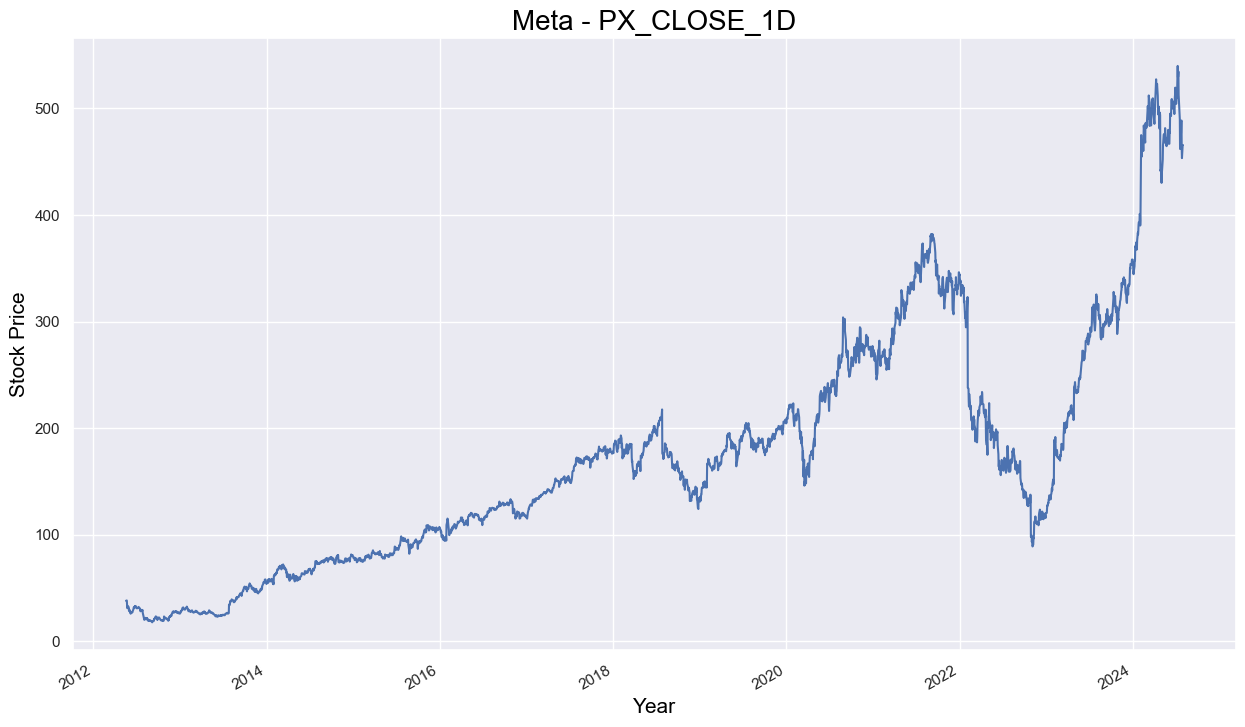

C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


C:\Users\navab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
RMSE score: 95.0619


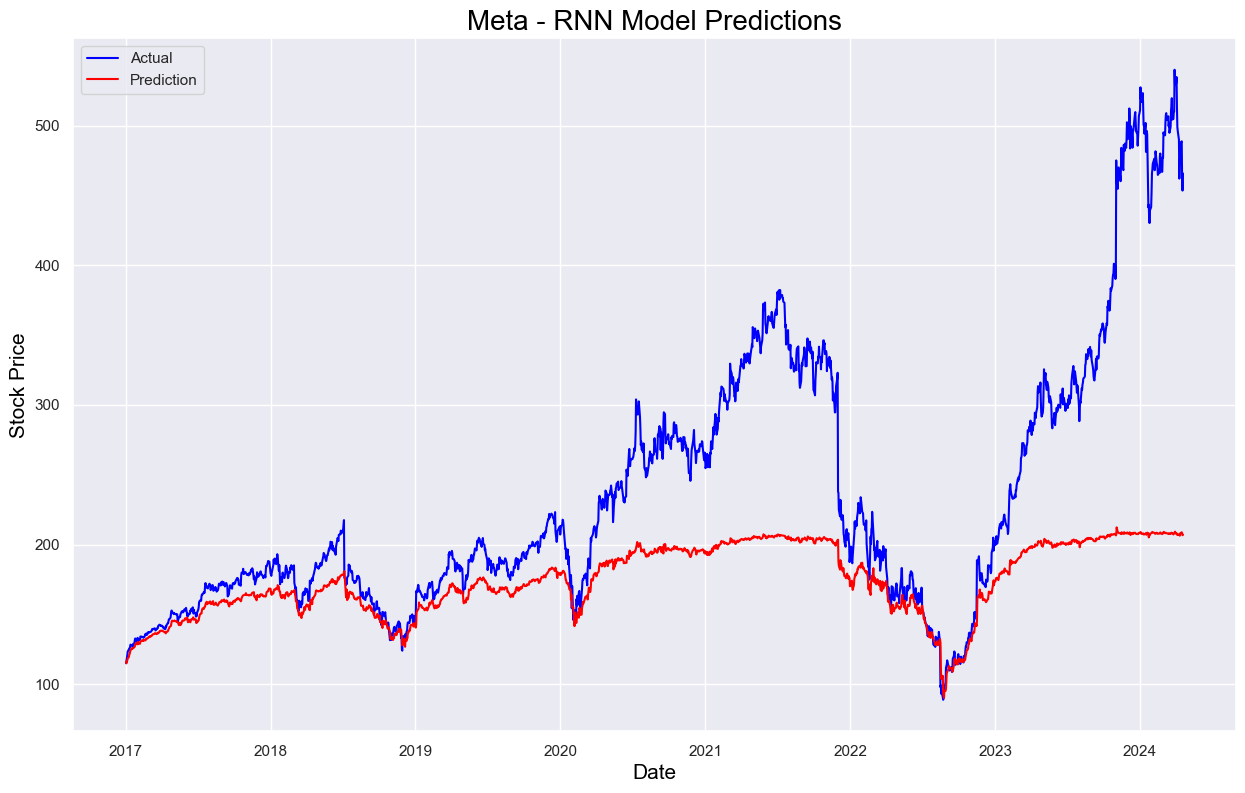

RMSE score: 59.4223


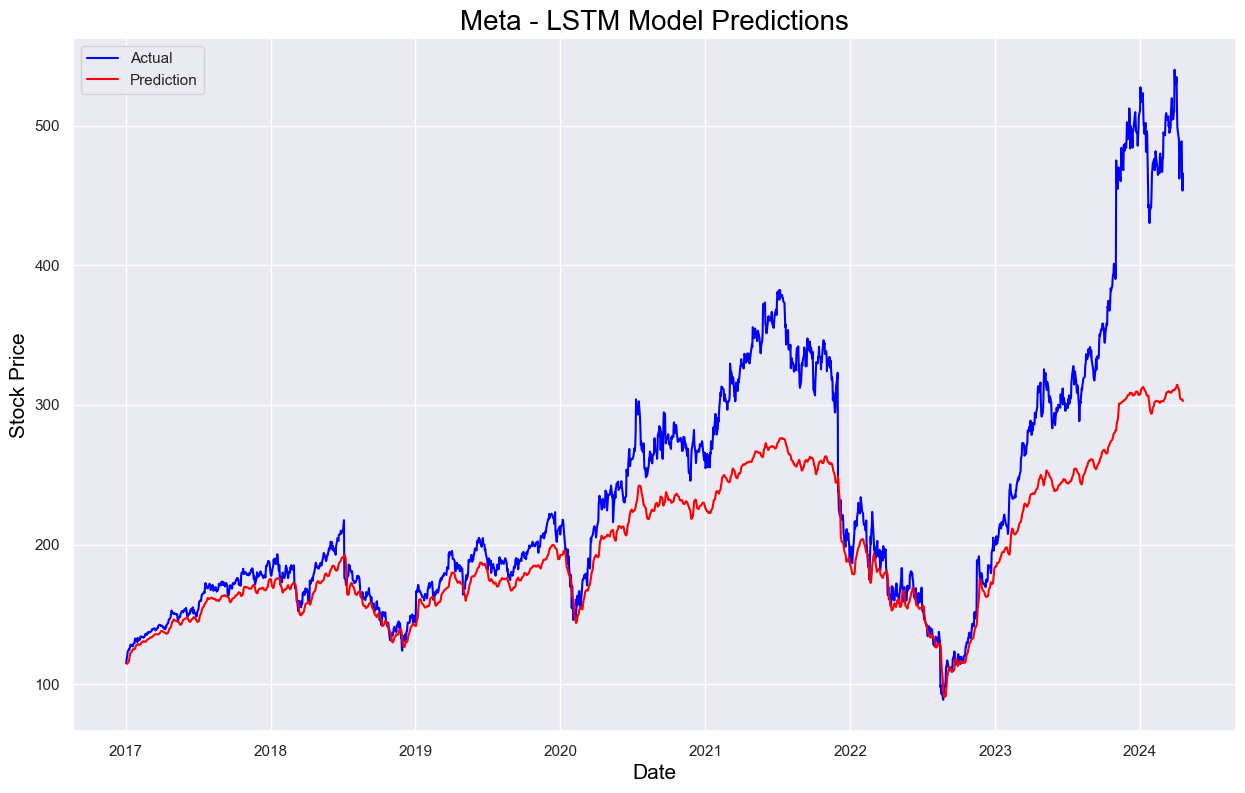

RMSE score: 26.7656


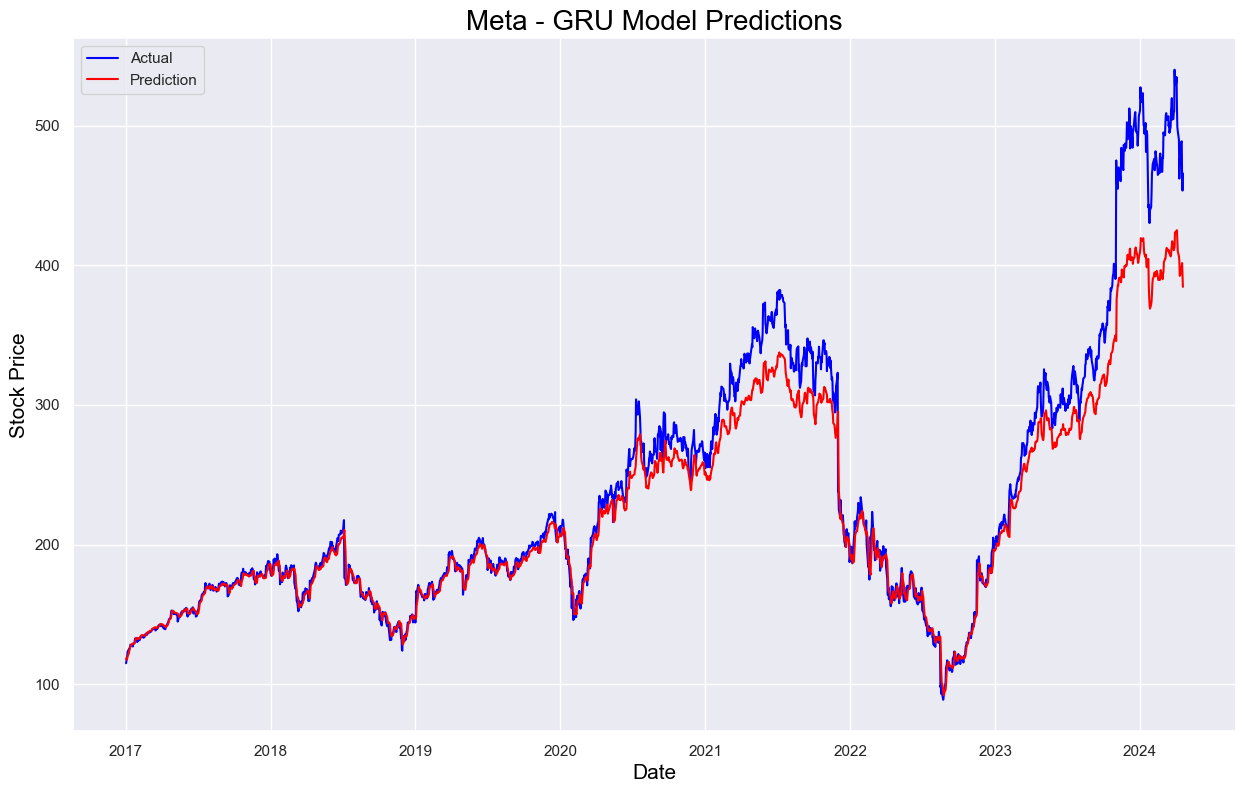

Meta - RNN RMSE: 95.0619
Meta - LSTM RMSE: 59.4223
Meta - GRU RMSE: 26.7656


In [37]:
# Iterate through each sheet and process the data
for sheet_name in excel_data.sheet_names:
    print(f"Processing sheet: {sheet_name}")
    data = excel_data.parse(sheet_name)
    process_company_data(sheet_name, data, time_steps=5, for_periods=2)